# XPSWMM 1D Inlet 2D Capture

A flat surface of 90ft is setup, then I added inflow at one end and a boundary at another end.

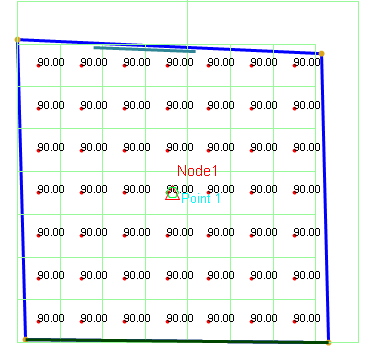

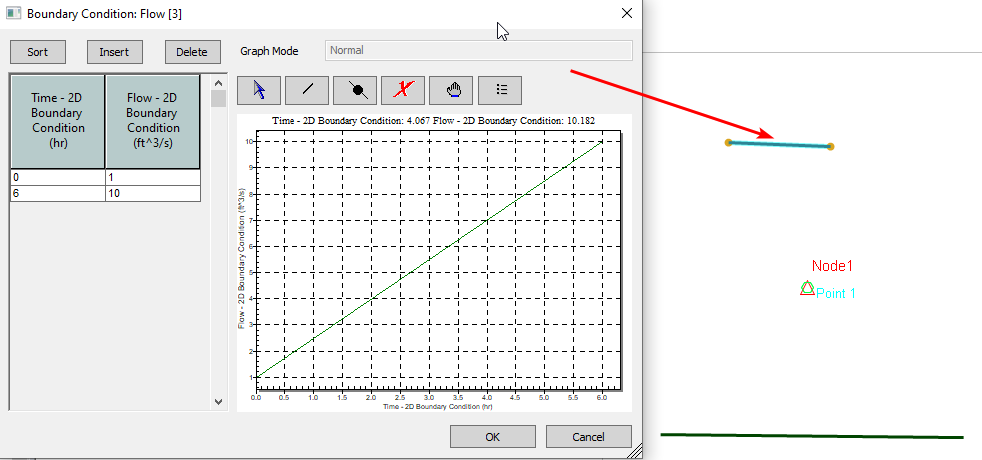

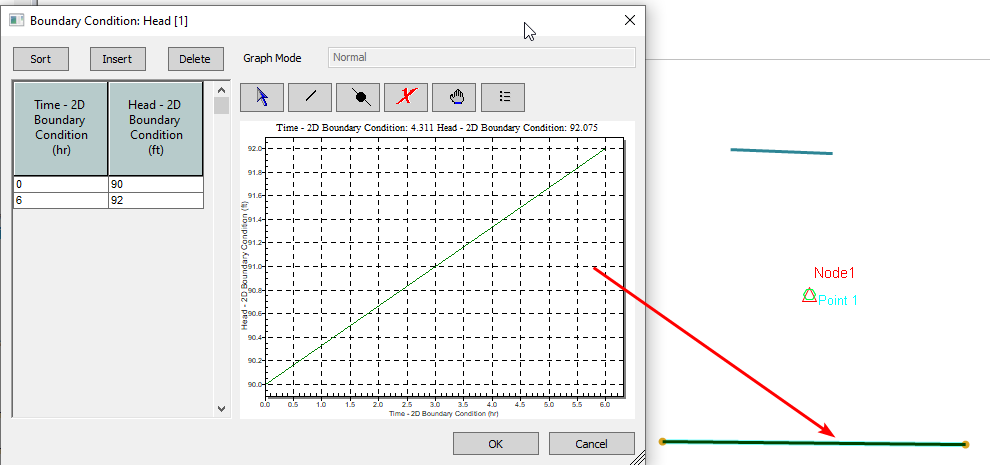

Then I added a storage node with 
- fixed area of 10000 sf
- invert of 85ft
- link to the crest the same as the 2D 90ft

With this model (1d_inlet.xp), I can calculate the flows into the storage node using the stage changes.

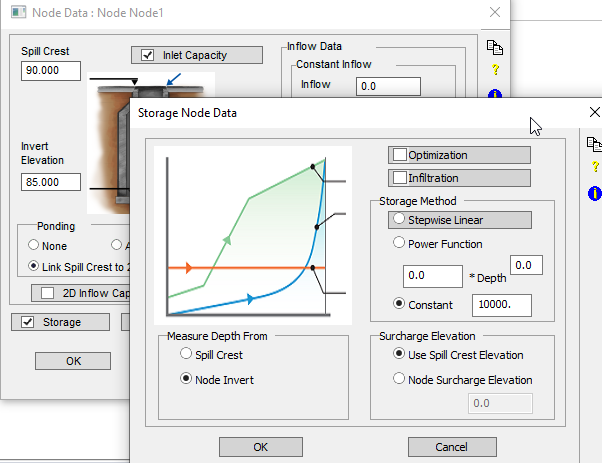

In another model(1d_inlet2.xp), I used the inlet directly so that I can get the flow directly from the inlet plot.

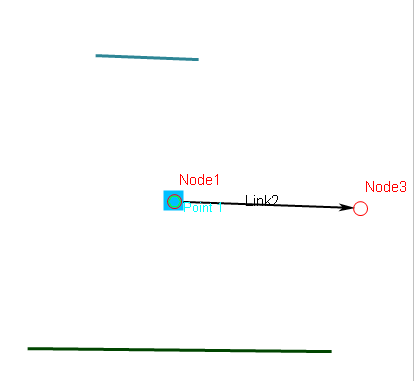

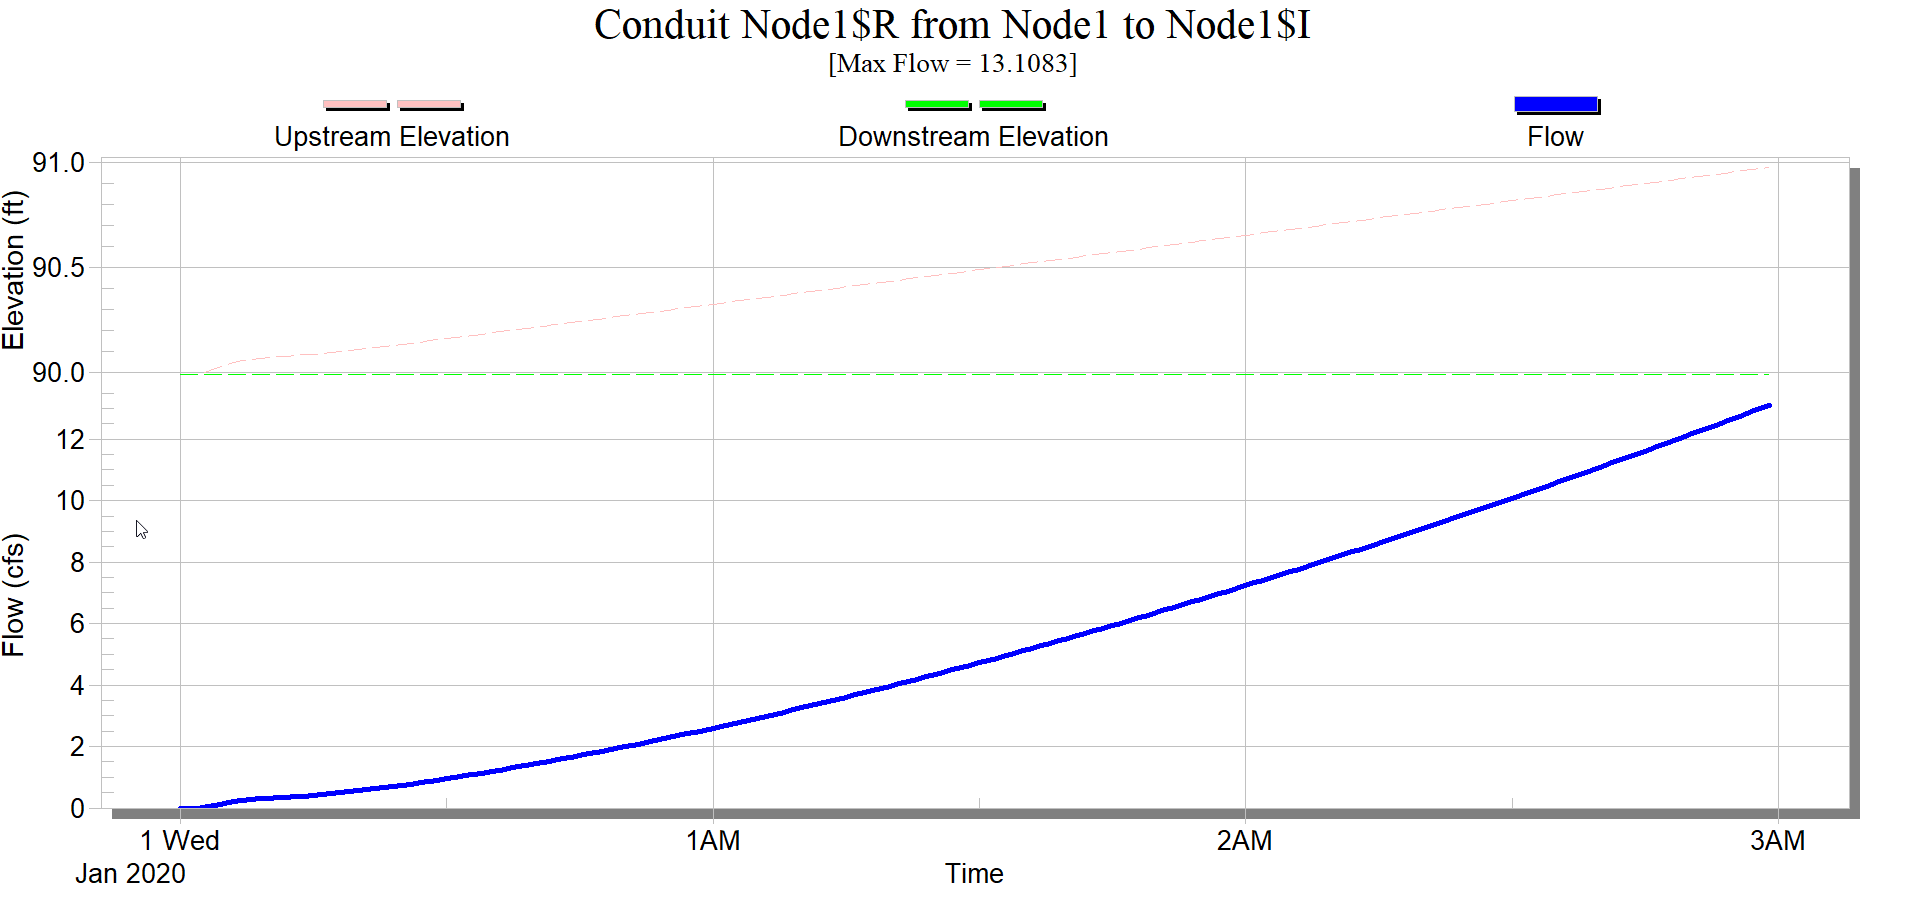

# Scenarios

I created the following scenarios,
* 2D capture Q=13.382*Depth^1.5
* Inlet fixed with 5cfs
* default not settings

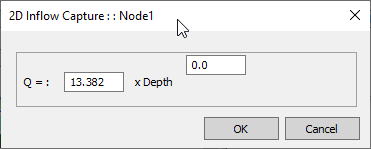

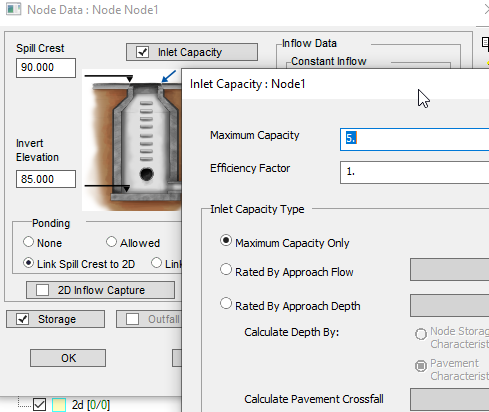

Water surface is reported as a head

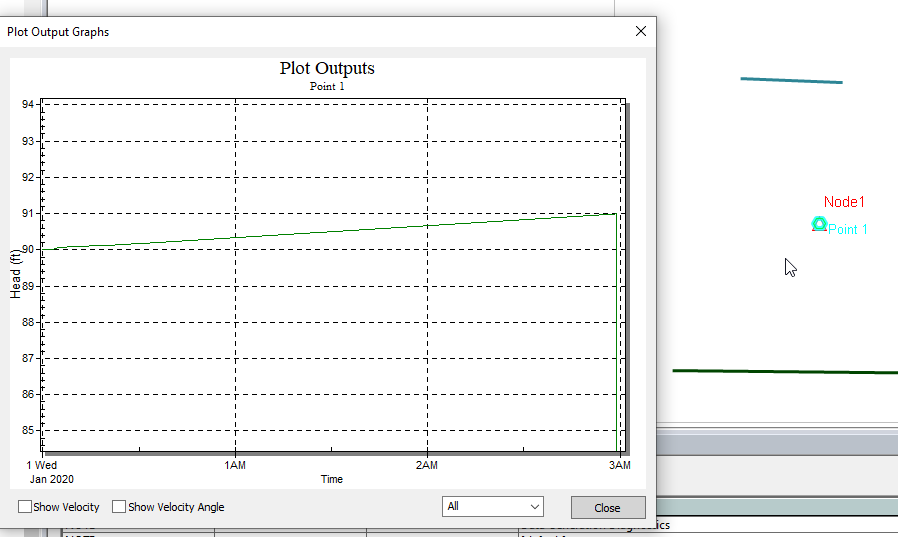

# Compare Results

I copy and pasted the results from XPSWMM to a csv file.

- ws_xxxxx: water surface at the node, most are reported from the 2D results, if the suffix is 'node' then it is reported from the inlet upstream end.
- flow_xxxx: for inlet modeled as storage node, it is calculated from the stage time series. For inlet it is reported flow
- stage_xxx: for inlet modeled as stroage node, stage is used to calculate flow
- min: simulation time in minutes


In [44]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

In [53]:
ws = r'C:\Users\Mel.Meng\Documents\GitHub\xpswmm\models\1d2d\data'

# for inlet modeled as storage flow = (stage@ts2- stage@ts1)*area/ts
area = 10000 # storage constant area in ft2
ts = 60.0 # time step in sec
rim = 90 # rim elevation in ft

csv_path = os.path.join(ws, '1d_inlet.csv')
df = pd.read_csv(csv_path)
for sc in scenarios:
    df['flow_%s' % sc] = df['stage_%s' % sc].diff()*area/ts
for fld in df.columns:
    if 'ws_' in fld: # convert water surface as depth above rim
        df[fld] = df[fld] - rim
    if 'stage_' in fld: # calculate flow rates from stage
        sc = fld.replace('stage_', '')
        df['flow_%s' % sc] = df[fld].diff()*area/ts      

df = df[df['min'] < 140]

# 2D Capture

2D capture uses the following equation,

- Q = 13.382*Depth^1.5
- 2d_capture: set the equation using the "2d capture" option (1d_inlet.xp)
- inlet_2d_capture: set the inlet depth curve using the equation (1d_inlet2.xp)




## 2D Capture Equation

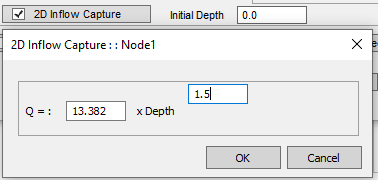

## Inlet Rated by Approach Depth

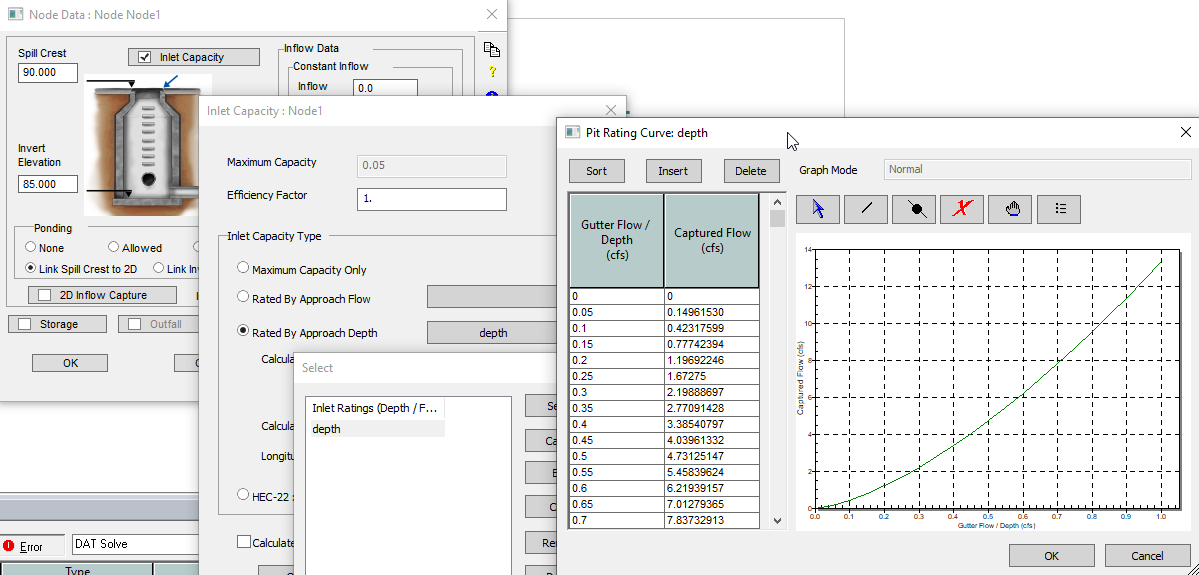

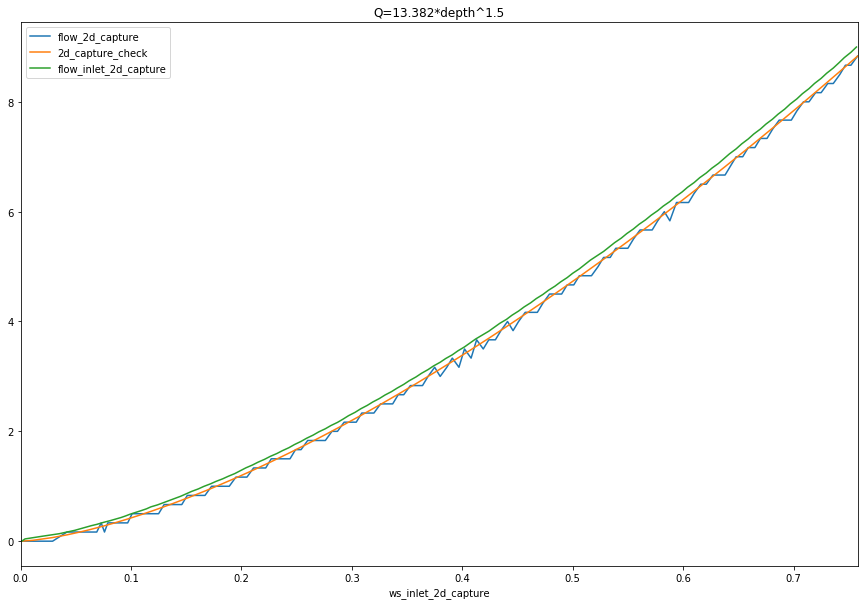

In [55]:
df.loc[df['ws_2d_capture']<0, 'ws_2d_capture'] = 0
df['2d_capture_check'] = np.power(df['ws_2d_capture'], 1.5)*13.382
ax = df.plot(x='ws_2d_capture', y='flow_2d_capture', figsize=(15,10))
df.plot(x='ws_2d_capture', y='2d_capture_check', ax=ax)
df.plot(x='ws_inlet_2d_capture', y='flow_inlet_2d_capture', ax=ax)
ax.set_title('Q=13.382*depth^1.5')
plt.show()

As shown in the figure above,
- orange is calculated using the depth and the equation
- green is using an inlet with a depth curve
- blue is using the 2D capture option

The 2d capture matches the calculation very well. Using the inlet with a depth curve is slightly higher. Also it seems that using a storage node is causing some stability issues with the flow.


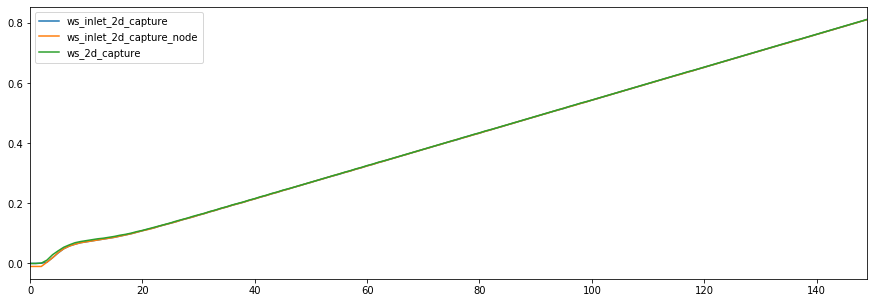

In [35]:
df.loc[:, ['ws_inlet_2d_capture', 'ws_inlet_2d_capture_node', 'ws_2d_capture']].plot(figsize=(15,5))

The figure above compares the water depth at the inlet over time,
- orange: reported as the upstream end depth from the inlet (1d_inlet2.xp)
- green: 2D reported water depth using 2D capture option(1d_inlet.xp)
- blue: 2D  reported water depth using depth curve (1d_inlet2.xp)

The depth reported for the inlet as upstream end is slightly lower than the 2D reported values, but in general they are very close as expected.

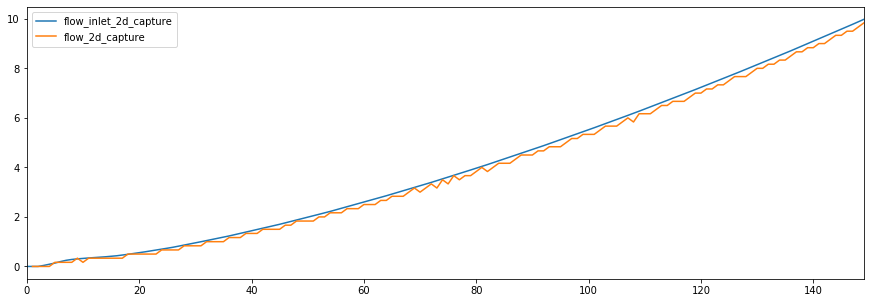

In [38]:
df.loc[:, ['flow_inlet_2d_capture', 'flow_2d_capture']].plot(figsize=(15,5))

The figure above compare the flow over time, and they are pretty close.

# Fixed Inlet

A 5cfs limit was used, and as shown below, when the flow, when the water level less than 0.25 there is problem to sustain 5cfs flow into the inlet, which is causing a pump like behavior. Once the depth is high enough, a 5cfs is sustained.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001C5030B57B8>,
      dtype=object)

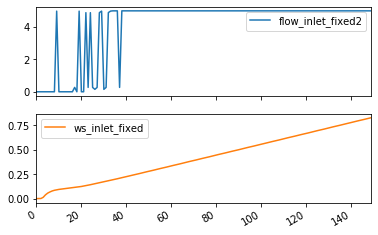

In [51]:
df['ws_inlet_fixed'] = df['ws_inlet_fixed'] - rim
df.loc[:, ['flow_inlet_fixed2', 'ws_inlet_fixed']].plot(subplots=True)

Also the comparison of the water depth from 2D and 1D inlet also showed the problem at the first 40 min, the engine has trouble to sustain the 5cfs and the head reported by 1D and 2D is quite different.

- ws_inlet_fixed2: reported as the inlet depth
- ws_inlet_fixed: reported from 2D point head

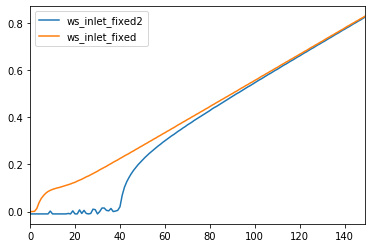

In [53]:
df.loc[:, ['ws_inlet_fixed2', 'ws_inlet_fixed']].plot(subplots=False)

# Default

Default is a little tricky. It is a linear relationship, but the value is not the defaul 13.382 used in XPSWMM. Need to check more about it.

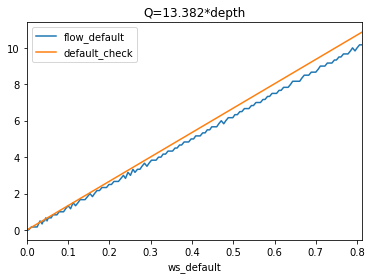

In [29]:
ax = df.plot(x='ws_default', y='flow_default')
df.plot(x='ws_default', y='default_check', ax=ax)
ax.set_title('Q=13.382*depth')
plt.show()

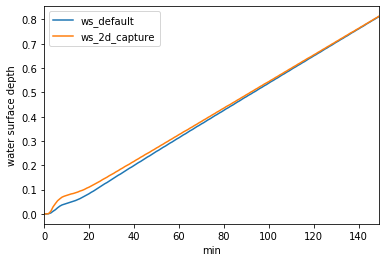

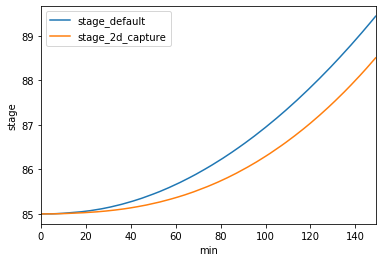

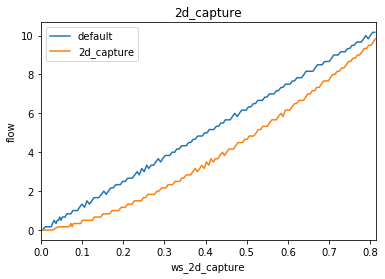

In [28]:
df = df.loc[df['min'] < 150]

df.loc[:, ['ws_%s' % x for x in scenarios]].plot(subplots=False)
plt.xlabel('min')
plt.ylabel('water surface depth')
plt.show()

df.loc[:, ['stage_%s' % x for x in scenarios]].plot(subplots=False)

plt.xlabel('min')
plt.ylabel('stage')
plt.show()

ax = None
for sc in scenarios:
    
#     df.plot(x='ws_%s' % sc, y='flow_%s' % sc, label=sc)
#     plt.title(sc)
    if ax is None:
        ax = df.plot(x='ws_%s' % sc, y='flow_%s' % sc, label=sc)
    else:
        df.plot(x='ws_%s' % sc, y='flow_%s' % sc, label=sc, ax=ax)
        ax.set_title(sc)
        ax.set_ylabel('flow')
        ax = None
        plt.show()
        
plt.show()